In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['annotation', 'all-dogs']


# Libraries

In [2]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator,save_img,load_img,img_to_array
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Input, Dense, Subtract, Flatten, Multiply, Concatenate, GlobalMaxPool2D,\
GlobalAvgPool2D, Dropout, LeakyReLU, GlobalMaxPool1D, GlobalAvgPool1D, GaussianNoise,\
BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras import losses
from keras.utils import to_categorical
from keras.initializers import RandomNormal


import keras.backend as K
import scipy



import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import math


Using TensorFlow backend.


In [3]:
from keras import backend as K
from keras.engine import *
from keras.legacy import interfaces
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from keras.legacy import interfaces
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf

class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 
        
class _ConvSN(Layer):

    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 spectral_normalization=True,
                 **kwargs):
        super(_ConvSN, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.spectral_normalization = spectral_normalization
        self.u = None
        
    def _l2normalize(self, v, eps=1e-12):
        return v / (K.sum(v ** 2) ** 0.5 + eps)
    
    def power_iteration(self, u, W):
        '''
        Accroding the paper, we only need to do power iteration one time.
        '''
        v = self._l2normalize(K.dot(u, K.transpose(W)))
        u = self._l2normalize(K.dot(v, W))
        return u, v
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        #Spectral Normalization
        if self.spectral_normalization:
            self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                     initializer=initializers.RandomNormal(0, 1),
                                     name='sn',
                                     trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        
        if self.spectral_normalization:
            W_shape = self.kernel.shape.as_list()
            #Flatten the Tensor
            W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
            _u, _v = power_iteration(W_reshaped, self.u)
            #Calculate Sigma
            sigma=K.dot(_v, W_reshaped)
            sigma=K.dot(sigma, K.transpose(_u))
            #normalize it
            W_bar = W_reshaped / sigma
            #reshape weight tensor
            if training in {0, False}:
                W_bar = K.reshape(W_bar, W_shape)
            else:
                with tf.control_dependencies([self.u.assign(_u)]):
                    W_bar = K.reshape(W_bar, W_shape)

            #update weitht
            self.kernel = W_bar
        
        if self.rank == 1:
            outputs = K.conv1d(
                inputs,
                self.kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.rank == 3:
            outputs = K.conv3d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    
class ConvSN1D(Conv1D):
    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                 initializer=initializers.RandomNormal(0, 1),
                 name='sn',
                 trainable=False)
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv1d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

class ConvSN3D(Conv3D):    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv3d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

        
class EmbeddingSN(Embedding):
    
    def build(self, input_shape):
        self.embeddings = self.add_weight(
            shape=(self.input_dim, self.output_dim),
            initializer=self.embeddings_initializer,
            name='embeddings',
            regularizer=self.embeddings_regularizer,
            constraint=self.embeddings_constraint,
            dtype=self.dtype)
        
        self.u = self.add_weight(shape=tuple([1, self.embeddings.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        self.built = True
        
    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
            
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.embeddings.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.embeddings, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.embeddings = W_bar
            
        out = K.gather(self.embeddings, inputs)
        return out 

class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True  
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h)
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)
            
        #Spectral Normalization    
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar
        
        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

# Crop Image

In [4]:
import os
import glob
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook
from skimage.transform import resize

class DogDataLoader():

    def __init__(self,batch_size):
        self.batch_size = batch_size
        
        all_dogs = glob.glob("../input/all-dogs/all-dogs/*")
        all_annotation = glob.glob("../input/annotation/Annotation/*/*")
        image_map={}
        for file in all_annotation:
            name = file.split("/")[-1]+".jpg"
            image_map[name] = file

        self.counter = 0
        self.imgs = []
#         for dog in tqdm_notebook(all_dogs[:200]):        
        for dog in tqdm_notebook(all_dogs):
            name = dog.split("/")[-1]
            path = image_map[name]
            tree = ET.parse(path)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') # reading bound box
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                temp = img_to_array(load_img(dog))[ymin:ymax,xmin:xmax,:]
                temp = resize(temp,(64,64))
                temp = temp/127.5 - 1.
                self.imgs.append(temp)
                self.imgs.append(temp[:,::-1,:])
                self.counter+=2
                
        print("total images:",self.counter)
        self.n = int(np.ceil(self.counter / self.batch_size)) 
        self.batch_counter = 0
        self.index = np.arange(self.counter)
        
    def reset_batch_size(self,batch_size):
        self.batch_size = batch_size
        self.n = int(np.ceil(self.counter / self.batch_size)) 
        self.batch_counter = 0
        self.index = np.arange(self.counter)
        
        
    def __iter__(self):
        return self
    
    def __next__(self): 
        batch_x = [self.imgs[i] for i in self.index[self.batch_counter * self.batch_size:(self.batch_counter + 1) * self.batch_size]]
        self.batch_counter+=1
        
        if self.batch_counter>self.n-1:
            self.batch_counter = 0
            np.random.shuffle(self.index)
  
        return np.array(batch_x),_

# Image Generator

In [5]:
batch_size = 32
real = DogDataLoader(batch_size)


total images: 44250


# Display Generator Image

In [6]:
# fig=plt.figure(figsize=(20, 10))
# columns = 8
# rows = 4
# img_batch,_ = next(real)
# for i in range(1, columns*rows +1):
#     fig.add_subplot(rows, columns, i)
#     x_temp = (img_batch[i-1]+1.)*127.5
#     plt.imshow(x_temp.astype(np.uint8))

# plt.show()

# DCGAN

https://raw.githubusercontent.com/DataSnaek/DCGAN-Keras/master/DCGAN.py

In [7]:
# def alr(model, epoch,every_epoch,name=""):
#     lr = model * (0.95 ** (epoch // every_epoch))
#     return lr

# def cyclic_learning_rate(model, epoch,eta_min,eta_max,T_max):
#     lr = eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2
#     return lr

# m = 0.0002
# ms = []
# T_max = 10
# for i in range(300):
#     m = alr(m,i,30)
# #     if math.cos(math.pi*i/T_max) > 0.9999:
# #         T_max*=T_mul
#     m = cyclic_learning_rate(m,i,0.00005,0.0002,20)
#     ms.append(m)
# plt.plot(ms)

In [8]:
from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization, Reshape, Dense, Input, LeakyReLU, Dropout, Flatten, ZeroPadding2D
from keras.optimizers import Adam

import glob
from PIL import Image
import numpy as np
import os
import argparse
from ast import literal_eval

import time




class DCGAN:
    def __init__(self,image_size = (64,64)):
        self.img_size = image_size
        self.upsample_layers = 5
        self.starting_filters = 64
        self.kernel_size = (4,4)
        self.channels = 3

        self.test_noise = np.random.normal(0, 1, (10, 100))
        self.init = RandomNormal(mean=0.0, stddev=0.02)
        
    def adjust_learning_rate(self,model, epoch,every_epoch,name=""): 

        lr = K.eval(model.optimizer.lr) * (0.95 ** (epoch // every_epoch))
        K.set_value(model.optimizer.lr, lr)
        if epoch%10==0:
            print(f"{name} lr: {K.eval(model.optimizer.lr)}")
            
    def cyclic_learning_rate(self,model,epoch,eta_min,eta_max,T_max,name=""):
        lr = eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2
        K.set_value(model.optimizer.lr,lr)
        if epoch%10==0:
            print(f"{name} lr: {K.eval(model.optimizer.lr)}")
        
    def build_generator(self):
        noise_shape = (100,)

        # This block of code can be a little daunting, but essentially it automatically calculates the required starting
        # array size that will be correctly upscaled to our desired image size.
        #
        # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
        # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
        # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
        # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
        model = Sequential()
        model.add(
            Dense(self.starting_filters * (self.img_size[0] // (2 ** self.upsample_layers))  *  (self.img_size[1] // (2 ** self.upsample_layers)),
                  activation="relu", kernel_initializer=self.init,input_shape=noise_shape))
        model.add(Reshape(((self.img_size[0] // (2 ** self.upsample_layers)),
                           (self.img_size[1] // (2 ** self.upsample_layers)),
                           self.starting_filters)))
        model.add(BatchNormalization(momentum=0.8))

#         model.add(UpSampling2D())  # 6x8 -> 12x16
        model.add(Conv2DTranspose(1024, kernel_size=self.kernel_size,strides=(2,2),kernel_initializer=self.init, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

#         model.add(UpSampling2D())  # 12x16 -> 24x32
        model.add(Conv2DTranspose(512, kernel_size=self.kernel_size,strides=(2,2),kernel_initializer=self.init, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

#         model.add(UpSampling2D())  # 24x32 -> 48x64
        model.add(Conv2DTranspose(256, kernel_size=self.kernel_size,strides=(2,2),kernel_initializer=self.init, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

#         model.add(UpSampling2D())  # 48x64 -> 96x128
        model.add(Conv2DTranspose(128, kernel_size=self.kernel_size,strides=(2,2),kernel_initializer=self.init, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

#         model.add(UpSampling2D())  # 96x128 -> 192x256
        model.add(Conv2DTranspose(64, kernel_size=self.kernel_size,strides=(2,2),kernel_initializer=self.init, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(32, kernel_size=self.kernel_size,kernel_initializer=self.init, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(self.channels, kernel_size=self.kernel_size,kernel_initializer=self.init, padding="same"))
        model.add(Activation("tanh"))

#         model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_size[0], self.img_size[1], self.channels)

        model = Sequential()

        model.add(Conv2D(32, kernel_size=self.kernel_size, strides=2, input_shape=img_shape,kernel_initializer=self.init, padding="same"))  # 192x256 -> 96x128
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=self.kernel_size, strides=2,kernel_initializer=self.init, padding="same"))  # 96x128 -> 48x64
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(128, kernel_size=self.kernel_size, strides=2,kernel_initializer=self.init, padding="same"))  # 48x64 -> 24x32
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(256, kernel_size=self.kernel_size, strides=1,kernel_initializer=self.init, padding="same"))  # 24x32 -> 12x16
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, kernel_size=self.kernel_size, strides=1,kernel_initializer=self.init, padding="same"))  # 12x16 -> 6x8
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(DenseSN(1, activation='sigmoid'))

#         model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    def build_fast_gan(self,sess):
        noise = Input(shape=(100,))
        real_image = Input(shape=(self.img_size[0], self.img_size[1], self.channels))
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        fake_image = self.generator(noise)
        
        fake_score = self.discriminator(fake_image)
        real_score = self.discriminator(real_image)
        
        def log_eps(i):
            return K.log(i+1e-11)
        
        dloss_real = -K.mean(0.1*log_eps(1-real_score) + 0.9*log_eps(real_score))
        
        dloss_fake = -K.mean(log_eps(1-fake_score))
        
        gloss = -K.mean(log_eps(fake_score))
        
        Adam = tf.train.AdamOptimizer
        optimizer = Adam(0.0002,0.5)
        
        grad_loss_real_wd = optimizer.compute_gradients(dloss_real,self.discriminator.trainable_weights)
        update_real_wd = optimizer.apply_gradients(grad_loss_real_wd)
        
        grad_loss_fake_wd = optimizer.compute_gradients(dloss_fake,self.discriminator.trainable_weights)
        update_fake_wd = optimizer.apply_gradients(grad_loss_fake_wd)
        
#         optimizer2 = Adam(0.00005,0.5)
        grad_loss_wg = optimizer.compute_gradients(gloss,self.generator.trainable_weights)
        update_wg = optimizer.apply_gradients(grad_loss_wg)
        
        sess.run(tf.global_variables_initializer())
        
        def get_internal_updates(model):
            inbound_nodes = model._inbound_nodes
            input_tensors = []
            for ibn in inbound_nodes:
                input_tensors+= ibn.input_tensors
            updates = [model.get_updates_for(i) for i in input_tensors]
            return updates
        other_parameter_updates = [get_internal_updates(m) for m in [self.discriminator,self.generator]]
        train_step = [update_real_wd, update_fake_wd,update_wg, other_parameter_updates]
        losses = [dloss_real,dloss_fake,gloss]
        learning_phase = K.learning_phase()
        
        def gan_feed(sess,batch_image,z_input):
            # actual GAN trainer
            nonlocal train_step,losses,noise,real_image,learning_phase

            res = sess.run([train_step,losses],feed_dict={
            noise:z_input,
            real_image:batch_image,
            learning_phase:True,
            # Keras layers needs to know whether
            # this run is training or testring (you know, batch norm and dropout)
            })

            loss_values = res[1]
            return loss_values #[dloss_real,dloss_fake,gloss]

        return gan_feed
    
    def train_fast_gan(self, epochs, image_generator, batch_size=32):
        if not os.path.exists('../epoch_output/'):
            os.makedirs('../epoch_output/')
        sess = K.get_session()
       
        gan_feed = self.build_fast_gan(sess)
        start = time.time()
        steps = image_generator.counter//batch_size
        self.losses = []
        
        for epoch in range(epochs):
#             self.adjust_learning_rate(self.discriminator,epoch,30,"discriminator")
#             self.adjust_learning_rate(self.combined,epoch,30,"generator")
#             self.cyclic_learning_rate(self.discriminator,epoch,0.00005,0.0002,10,"discriminator")
#             self.cyclic_learning_rate(self.combined,epoch,0.00005,0.0002,10,"generator")
        
#             for step in tqdm_notebook(range(steps)):
            for step in range(steps):
                real_imgs,_ = next(image_generator)
                
                current_batch_size = real_imgs.shape[0]

                noise = np.random.normal(0, 1, (current_batch_size, 100))
                losses = gan_feed(sess,real_imgs,noise)
                self.losses.append(losses)
                # Print progress
            if epoch%10==0:
                print(f"{epoch} [D loss: {self.losses[-1][0]}] [D loss: {self.losses[-1][1]}] [G loss: {self.losses[-1][2]}]")
#                 fake_noise = self.generator.predict(self.test_noise)
#                 fig=plt.figure(figsize=(10, 5))
#                 columns = 5
#                 rows = 2
#                 for i in range(1, columns*rows +1):
#                     fig.add_subplot(rows, columns, i)
#                     x_temp = (fake_noise[i-1]+1.)*127.5  
#                     plt.imshow(x_temp.astype(np.uint8))
#                 plt.savefig(f"../epoch_output/fake_{epoch:05d}.jpg",bbox_inches = 'tight')
                
#                 fig=plt.figure(figsize=(10, 5))
#                 n = 1382
#                 plt.plot(range(n),[i[0] for i in self.losses[-n:]],label ="d_loss_real")
#                 plt.plot(range(n),[i[1] for i in self.losses[-n:]],label = "d_loss_fake")
#                 plt.plot(range(n),[i[2] for i in self.losses[-n:]],label = "g_loss")
#                 plt.legend()

#                 plt.show()
            if time.time() - start >8.8*3600:
                break
                # If at save interval => save generated image samples, save model files
        print(f"time spend: {time.time()-start}s")


    def build_gan(self):
        d_opt = Adam(0.0002, 0.5)
#         g_opt = Adam(0.00005, 0.5)
        g_opt = Adam(0.0002, 0.5)

        # See if the specified model paths exist, if they don't then we start training new models


        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=d_opt,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=g_opt)

        # These next few lines setup the training for the GAN model
        z = Input(shape=(100,))
        img = self.generator(z)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=g_opt)
        
    def smooth_positive_labels(self,y):
        return y - 0.3 + (np.random.random(y.shape) * 0.5) 
    
    def smooth_negative_labels(self,y):
        return y + np.random.random(y.shape) * 0.3   
        
    def train(self, epochs, image_generator, batch_size=32):
        if not os.path.exists('../epoch_output/'):
            os.makedirs('../epoch_output/')
        self.build_gan()
        start = time.time()
        steps = image_generator.counter//batch_size
        self.d_loss = []
        self.g_loss = []

        for epoch in range(epochs):
#             self.adjust_learning_rate(self.discriminator,epoch,30,"discriminator")
#             self.adjust_learning_rate(self.combined,epoch,30,"generator")
            self.cyclic_learning_rate(self.discriminator,epoch,0.00005,0.0002,10,"discriminator")
            self.cyclic_learning_rate(self.combined,epoch,0.00005,0.0002,10,"generator")
        
            for step in tqdm_notebook(range(steps)):
#             for step in range(steps):
                real_imgs,_ = next(image_generator)
#                 real_imgs = real_imgs/127.5 - 1.
                
                current_batch_size = real_imgs.shape[0]
                # Train Generator
                noise = np.random.normal(0, 1, (current_batch_size, 100))
                g_loss = self.combined.train_on_batch(noise, np.ones((current_batch_size, 1)))
                self.g_loss.append(g_loss)
                # Train Discriminator
                                                      

                # Sample noise and generate a half batch of new images
                noise = np.random.normal(0, 1, (current_batch_size, 100))
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(real_imgs, 
                                                                self.smooth_positive_labels(np.ones((current_batch_size, 1))))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((current_batch_size, 1)))
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                self.d_loss.append(d_loss)
            
                # Print progress
            if epoch%10==0:
                print(f"{epoch} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")
#                 fake_noise = self.generator.predict(self.test_noise)
#                 fig=plt.figure(figsize=(20, 10))
#                 columns = 5
#                 rows = 2
#                 for i in range(1, columns*rows +1):
#                     fig.add_subplot(rows, columns, i)
#                     x_temp = (fake_noise[i-1]+1.)*127.5  
#                     plt.imshow(x_temp.astype(np.uint8))
#                 plt.savefig(f"../epoch_output/fake_{epoch:05d}.jpg",bbox_inches = 'tight')
#                 plt.show()
            if time.time() - start >8.8*3600:
                break
                # If at save interval => save generated image samples, save model files
        print(f"time spend: {time.time()-start}s")

    def gene_imgs(self, count):
        # Generate images from the currently loaded model
        noise = np.random.normal(0, 1, (count, 100))
        return self.generator.predict(noise)
    
    def generate_imgs(self, count=1, threshold=0.5,verbose=0):
        # Generates (count) images from the model ensuring the discriminator scores them between the threshold values
        # and saves them

        imgs = []
        for i in range(count):
            img = self.gene_imgs(1)
            imgs.append(img)

        imgs = np.asarray(imgs).squeeze()        
        return imgs
    


In [9]:
%%time
dcgan = DCGAN(image_size = (64,64))
dcgan.train_fast_gan(10000000,real,batch_size)

0 [D loss: 0.7211104035377502] [D loss: 0.7217194437980652] [G loss: 0.8258528113365173]
10 [D loss: 0.6296367645263672] [D loss: 0.43861228227615356] [G loss: 1.289840817451477]
20 [D loss: 0.63608318567276] [D loss: 0.4430011510848999] [G loss: 1.3218743801116943]
30 [D loss: 0.49873223900794983] [D loss: 0.4922976791858673] [G loss: 1.2659932374954224]
40 [D loss: 0.557178795337677] [D loss: 0.34178680181503296] [G loss: 1.451184868812561]
50 [D loss: 0.489316463470459] [D loss: 0.48724043369293213] [G loss: 1.4765613079071045]
60 [D loss: 0.64998459815979] [D loss: 0.5053400993347168] [G loss: 1.2624127864837646]
70 [D loss: 0.646776556968689] [D loss: 0.4106051027774811] [G loss: 1.5400142669677734]
80 [D loss: 0.7259089946746826] [D loss: 0.32002681493759155] [G loss: 1.6786022186279297]
90 [D loss: 0.6882596015930176] [D loss: 0.5474246144294739] [G loss: 1.0575703382492065]
100 [D loss: 0.4142679274082184] [D loss: 0.4944925308227539] [G loss: 1.1708173751831055]
110 [D loss: 0

# Fast GAN speed for 1 epochs
# 1:39
# Normal GAN speed for 1 epochs
# 2:44

In [10]:
# %%time
# dcgan = DCGAN(image_size = (64,64))
# dcgan.train(1,real,batch_size)

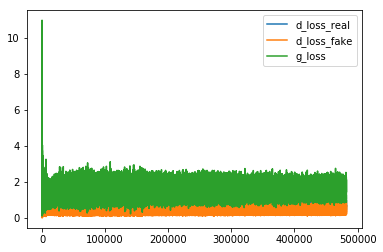

In [11]:
n = len(dcgan.losses)
plt.plot(range(n),[i[0] for i in dcgan.losses],label ="d_loss_real")
# plt.plot(range(n),[i[1] for i in dcgan.d_loss],label ="d_acc")
plt.plot(range(n),[i[1] for i in dcgan.losses],label = "d_loss_fake")
plt.plot(range(n),[i[2] for i in dcgan.losses],label = "g_loss")
plt.legend()
plt.show()

# Save model and epoch

In [12]:
dcgan.generator.save("model.h5")
import shutil
shutil.make_archive('epoch_output', 'zip', '../epoch_output')

'/kaggle/working/epoch_output.zip'

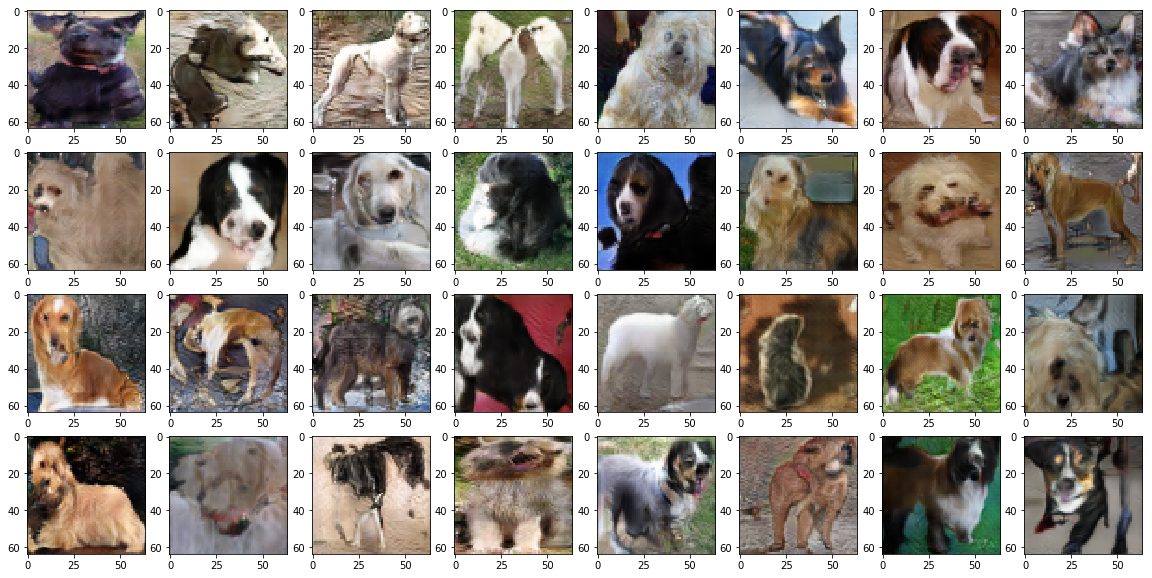

In [13]:
import cv2
fake = dcgan.generate_imgs(32)
fig=plt.figure(figsize=(20, 10))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    x_temp = (fake[i-1]+1.)*127.5
    plt.imshow(x_temp.astype(np.uint8))
plt.show()

# Save Images

In [14]:
import cv2
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in tqdm_notebook(range(0, n_images, im_batch_size)):
    fake_dogs = dcgan.generate_imgs(im_batch_size)
  
    for i_image in range(im_batch_size):
        temp = (fake_dogs[i_image, :, :, :]+1.)*127.5
        temp = temp.astype(np.uint8)
        save_img(os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'),temp)
import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'